# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print("We're using TF", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
We're using TF 2.1.0


In [13]:
from Utils import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

from Utils.keras_utils import reset_tf_session

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
from Utils import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.laod_dataset()

Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


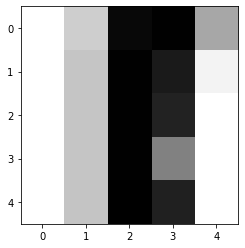

And the whole sample:


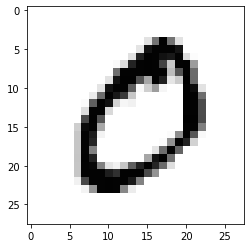

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [4]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Our task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

We will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [5]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [6]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [7]:
# run this again if you remake your graph
s = reset_tf_session()

In [8]:
# Model parameters: W and b
W = tf.get_variable(name='W', shape=(X_train_flat.shape[1], y_train_oh.shape[1]), dtype=tf.float32)### YOUR CODE HERE ### tf.get_variable(...) with shape[0] = 784
b = tf.get_variable(name='b', shape=(y_train_oh.shape[1], ), dtype=tf.float32)### YOUR CODE HERE ### tf.get_variable(...)

In [9]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None, X_train_flat.shape[1]), name='input_x')### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder('float32', shape=(None, y_train_oh.shape[1]), name='input_y')### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels

In [10]:
# Compute predictions
logits = input_X @ W + b### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits)### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = tf.argmax(probas, 1)### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits))### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)### YOUR CODE HERE ### optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
print(logits.shape)

(?, 10)


In [14]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdeVhV1frA8e%2BRAyKjMgmIioo5gAKCU86as9ccuEqaEw7ZcFPr3rS8lVam3fJXNy1NU0xN0SwyDU0TLW%2BDiDkhDmiAgIKAgoKADOv3x4mtxCCmggffz/Ps5wx77b3XOug55z1rrXfplFIKIYQQQgghhBD3Xa3qroAQQgghhBBCPCwkABNCCCGEEEKIKiIBmBBCCCGEEEJUEQnAhBBCCCGEEKKKSAAmhBBCCCGEEFVEAjAhhBBCCCGEqCISgAkhhBBCCCFEFZEATAghhBBCCCGqiARgQgghhBBCCFFFJAATQgghhBBCiCoiAZgQQgghhBBCVBEJwIQQQgghhBCiikgAJoQQQgghhBBVRAIwIYQQQgghhKgiEoAJIYQQQgghRBWRAEwIIYQQQgghqogEYEIIIYQQQghRRSQAE0IIIYQQQogqIgGYEEIIIYQQQlQRCcCEEHdMp9Nx9uzZ6q6GEEIIIYTRkQBMiAdMQUFBdVfhrtWENgghhDFSSlFUVFTd1RBCVEACMCGqUEJCAiNGjMDR0RF7e3uee%2B451qxZQ5cuXZg1axZ2dnbMmzePoqIi3nrrLRo3boyTkxPjx48nMzMTgNzcXJ588kns7e2pW7cu7du3JyUlBYA1a9bQtGlTrK2tadKkCZ9//nm5dTl16hR9%2B/bFzs6OFi1asHnzZm3fxIkTefbZZxk8eDDW1tZ07NiRc%2BfOAdC9e3cAvL29sbKyYtOmTezbtw83NzfeeecdnJ2dmTRpEgArV67Ew8MDOzs7hg4dyoULF7Rr6HQ6PvzwQ5o2bYqDgwP/%2Bte/KCoqIi8vDzs7O44fP66VvXTpEnXq1CE1NfUe/SWEEOL%2BWrRoEc2aNcPa2prWrVsTGhqq7Vu5ciWtWrXS9v32229A2Z8RAPPmzePJJ5/Ujo%2BLi0On02k/dvXs2ZO5c%2BfSpUsXLCws%2BP333wkODtau0bRpUz755JMS9du6dSs%2BPj7Y2NjQrFkzdu7cyRdffIGfn1%2BJcosXL2bYsGH35TUS4qGlhBBVoqCgQLVt21bNnDlTZWVlqZycHLV//34VHBysTExM1Icffqjy8/PV9evX1apVq1SzZs3UuXPn1LVr19Tw4cPVk08%2BqZRSavny5WrIkCEqOztbFRQUqMjISJWZmamysrKUtbW1OnXqlFJKqQsXLqioqKgy65KVlaXc3NzU6tWrVX5%2Bvjp06JCyt7fXyk%2BYMEHVq1dPHThwQOXn56sxY8ao0aNHa8cDKiYmRnu8d%2B9eZWJiol566SWVm5urrl%2B/rvbs2aPs7e3VoUOHVG5urnruuedUt27dSpyjZ8%2BeKj09XcXHx6vmzZurlStXKqWUevrpp9VLL72klf3ggw/UkCFD7tFfQggh7r/NmzerpKQkVVhYqEJCQpSFhYW6cOGC2rx5s3J1dVURERGqqKhIxcTEqLi4uHI/I5RS6vXXX1djx47Vzh0bG6sAlZ%2Bfr5RSqkePHqphw4YqKipK5efnqxs3bqjt27ers2fPqqKiIrVv3z5Vp04ddejQIaWUUgcOHFA2NjZq165dqrCwUCUmJqqTJ0%2Bq3NxcVa9ePRUdHa1dy8fHR23ZsqUKXzkhaj4JwISoIj///LNycHDQPjCLBQcHq4YNG5Z4rnfv3uqjjz7SHp86dUrp9XqVn5%2BvVq1apTp37qyOHj1a4pisrCxla2urtmzZoq5fv15hXUJCQlTXrl1LPDdt2jQ1b948pZQhAJs8ebK279tvv1UtWrTQHpcVgJmamqqcnBztuaCgIPWvf/1Le3zt2jWl1%2BtVbGysdo4dO3Zo%2Bz/66CPVu3dvpZRSv/76q3Jzc1OFhYVKKaX8/PzUpk2bKmyTEEI8yLy9vdXXX3%2Bt%2BvXrpz744INS%2B8v7jFCqcgHYq6%2B%2BWuH1H3/8ce2606ZNUzNnziyz3PTp09Urr7yilFIqKipK1a1bV%2BXm5laukUKISpEhiEJUkYSEBBo3boxery%2B1r2HDhiUeX7hwgcaNG2uPGzduTEFBASkpKYwbN47%2B/fsTGBiIq6srL730Evn5%2BVhaWrJp0yaWL1%2BOi4sLgwcP5tSpUwB4enpiZWWFlZUV%2B/fvJz4%2BngMHDlC3bl1t%2B/zzz0lOTtau6ezsrN23sLAgKyurwvY5Ojpibm5ebhusrKywt7cnKSmpzHY3btxYG6LYsWNHLC0t%2BeGHHzh16hRnz55l6NChFV5fCCEeJGvXrsXHx0d7j42KiiItLY2EhASaNWtWqnxFnxGV8efPkR07dtCpUyfs7OyoW7cuYWFhpKWladcqqw4AEyZMYMOGDSilWLduHaNGjaJ27dp/qU5CiLJJACZEFWnYsCHnz58vM0GFTqcr8djV1ZX4%2BHjt8fnz59Hr9dSvXx9TU1Nef/11oqOj%2Bfnnn9m%2BfTtr164FoH///uzevZuLFy/SsmVLpk6dCsCJEyfIysoiKyuLbt260bBhQ3r06EFGRoa2ZWVlsWzZsr/cvtu1ITs7m/T0dBo0aKA9l5CQUKKNrq6u2uMJEyawfv161q1bR0BAQIngTgghHmTx8fFMnTqVpUuXkp6eTkZGBl5eXiilaNiwoTan9lYVfUZYWlpy/fp17fGtP5YVu/U9OC8vj5EjR/LPf/6TlJQUMjIyGDRoEEop7Vpl1QGgU6dOmJmZsX//fjZs2MC4cePuuP1CiIpJACZEFenQoQMuLi7MmTOH7OxscnNz%2Bemnn8os%2B8QTT/D%2B%2B%2B8TGxtLVlYWr7zyCqNHj0av17N3716OHz9OYWEhNjY2mJqaYmJiQkpKCt988w3Z2dnUrl0bKysrTExMyjz/kCFDOHPmDOvWrSM/P5/8/HwOHjzIyZMnK9WW%2BvXr8/vvv1dYZsyYMQQHB3PkyBHy8vJ45ZVX6NixI%2B7u7lqZd999lytXrpCQkMB///tfRo8ere0bN24coaGhrF%2B/nvHjx1eqXkII8SDIzs5Gp9Ph6OgIQHBwMFFRUQBMmTKF9957j0OHDqGU4uzZs8THx1f4GeHj48OPP/7I%2BfPnyczMZOHChRVe/8aNG%2BTl5eHo6Iher2fHjh3s2rVL2z958mSCg4PZs2cPRUVFJCUlaSMmAMaPH89zzz2HXq%2Bna9eu9/rlEeKhJwGYEFXExMSEbdu2cfbsWRo1aoSbmxubNm0qs2xQUBDjxo2je/fuNGnSBHNzc5YsWQIYfvkMCAjAxsaGVq1a0aNHD5588kmKiopYvHgxrq6u2NnZ8cMPP/Dxxx%2BXeX5ra2t27dpFSEgIrq6uODs7M3v2bPLy8irVlnnz5jFhwgTq1q1bInvirfr06cObb77JyJEjcXFx4dy5c4SEhJQo8/jjj%2BPn54ePjw%2BDBw9m8uTJ2j43NzfatWuHTqejW7dulaqXEEI8CFq3bs2LL75I586dqV%2B/PsePH6dLly4A/P3vf2fu3LmMGTMGa2trhg0bxuXLlyv8jOjbty%2BjR4%2Bmbdu2%2BPn5MWTIkAqvb21tzYcffsioUaOoV68eGzZsKDGMu0OHDgQHBzNr1ixsbW3p0aNHiREL48aNIyoqSnq/hLhPdKq4P1oIIaqQTqcjJiYGDw%2BPcssEBQXh6urKW2%2B9VYU1E0KIh1tOTg5OTk789ttvNG/evLqrI0SN89dmegohxH0WFxfHV199xeHDh6u7KkII8VBZtmwZ7d

# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.



In [15]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###
# define a two layer MLP
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid) # layer 1 after input layer
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid) # layer 2 adjacent to layer 1
logits = tf.layers.dense(hidden2, 10) # as we have 10 classes as output

# define the prediction probabilities and calsses layer
probas = tf.nn.softmax(logits) # as we have multiple classes here
classes = tf.argmax(probas, 1) # 1 is axis i.e column vector containing 10 values of probabilities

# define the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))

# define our gradient descent step
step = tf.train.AdamOptimizer().minimize(loss)

# Now let's moveforward to train our network

#sess = reset_tf_session()
s.run(tf.global_variables_initializer())
# define the batchsize and no of epochs
BATCH_SIZE_MLP = 512
EPOCHS_MLP = 40

# for logging the progress right here
simpleTrainingCurvesMLP = matplotlib_utils.SimpleTrainingCurves('cross-entropy', 'accuracy')

# iterate for no of epochs
for epoch in range(EPOCHS_MLP):
    
    batch_losses_MLP = []
    for start in range(0, X_train_flat.shape[0], BATCH_SIZE_MLP):
        _, batch_loss = s.run([step, loss],
                                {input_X:X_train_flat[start : start + BATCH_SIZE_MLP],
                                input_y : y_train_oh[start : start + BATCH_SIZE_MLP]})
        batch_losses_MLP.append(batch_loss)
        
    train_loss = np.mean(batch_losses_MLP)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})
    training_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))
    val_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))
    simpleTrainingCurvesMLP.add(train_loss, val_loss, training_accuracy, val_accuracy)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdeVxV1fr48c%2BRQQVBBNHAwyiKggwKjilappbzQE45T9fSbtlgVter3bpl3%2BpXmaZXMzRL0SzTyjEcG5xTMydQQAZTQEDmcf3%2B2LGVAKdkOPq8X6/zOmfPa2/OPpznrLWeZVBKKYQQQgghhBBCVLpa1V0AIYQQQgghhLhfSAAmhBBCCCGEEFVEAjAhhBBCCCGEqCISgAkhhBBCCCFEFZEATAghhBBCCCGqiARgQgghhBBCCFFFJAATQgghhBBCiCoiAZgQQgghhBBCVBEJwIQQQgghhBCiikgAJoQQQgghhBBVRAIwIYQQQgghhKgiEoAJIYQQQgghRBWRAEwIIYQQQgghqogEYEIIIYQQQghRRSQAE0IIIYQQQogqIgGYEEIIIYQQQlQRCcCEEEIIIYQQoopIACaEEEIIIYQQVUQCMCGEEEIIIYSoIhKACSFum8FgICoqqrqLIYQQQghhciQAE6KGKSwsrO4i/G33wjkIIYQpUkpRXFxc3cUQQtyABGBCVKG4uDgGDx6Mo6MjDg4OTJ8%2BneXLl/Pggw8yY8YM7O3tmTt3LsXFxbzxxhu4ubnRqFEjxowZQ3p6OgC5ubmMGjUKBwcH7OzsaNu2LZcuXQJg%2BfLleHp6YmNjg4eHB1988UWFZTl9%2BjQ9evTA3t4eb29v1q5dqy8bN24c06ZNo0%2BfPtjY2NC%2BfXvOnTsHQEhICAABAQHUq1ePNWvWsGvXLoxGI2%2B//TYPPPAA48ePB2Dp0qV4eXlhb29P//79SUxM1I9hMBiYP38%2Bnp6eNGzYkBdffJHi4mLy8vKwt7fnt99%2B09e9fPkydevWJSkp6S79JYQQonLNmzePpk2bYmNjg4%2BPD%2BvXr9eXLV26lJYtW%2BrLjhw5ApT/PwJg7ty5jBo1St8%2BJiYGg8Gg/9jVrVs3Xn31VR588EGsrKw4f/48YWFh%2BjE8PT353//%2BV6p8GzZsIDAwEFtbW5o2bcqWLVv48ssvCQoKKrXee%2B%2B9x8CBAyvlGglx31JCiCpRWFio/P391bPPPqsyMzNVTk6O2rt3rwoLC1NmZmZq/vz5qqCgQGVnZ6tly5appk2bqnPnzqmMjAw1aNAgNWrUKKWUUosXL1Z9%2B/ZVWVlZqrCwUB06dEilp6erzMxMZWNjo06fPq2UUioxMVGdOHGi3LJkZmYqo9GoPv30U1VQUKAOHz6sHBwc9PXHjh2rGjRooPbv368KCgrUyJEj1bBhw/TtARUZGalP79y5U5mZmamZM2eq3NxclZ2drSIiIpSDg4M6fPiwys3NVdOnT1ddunQptY9u3bqplJQUFRsbq5o1a6aWLl2qlFLqySefVDNnztTX/eCDD1Tfvn3v0l9CCCEq39q1a1VCQoIqKipS4eHhysrKSiUmJqq1a9cqZ2dndeDAAVVcXKwiIyNVTExMhf8jlFJqzpw56oknntD3HR0drQBVUFCglFKqa9euysXFRZ04cUIVFBSo/Px89d1336moqChVXFysdu3aperWrasOHz6slFJq//79ytbWVm3btk0VFRWp%2BPh4derUKZWbm6saNGigTp48qR8rMDBQrVu3rgqvnBD3PgnAhKgiP//8s2rYsKH%2BD7NEWFiYcnFxKTXv4YcfVgsXLtSnT58%2BrczNzVVBQYFatmyZ6tixozp27FipbTIzM1X9%2BvXVunXrVHZ29g3LEh4erjp37lxq3pQpU9TcuXOVUloANnHiRH3Z999/r7y9vfXp8gIwCwsLlZOTo8%2BbMGGCevHFF/XpjIwMZW5urqKjo/V9bN68WV%2B%2BcOFC9fDDDyullNq3b58yGo2qqKhIKaVUUFCQWrNmzQ3PSQgharKAgAD1zTffqJ49e6oPPvigzPKK/kcodWsB2OzZs294/AEDBujHnTJlinr22WfLXW/q1KnqlVdeUUopdeLECWVnZ6dyc3Nv7SSFELdEmiAKUUXi4uJwc3PD3Ny8zDIXF5dS04mJibi5uenTbm5uFBYWcunSJUaPHk2vXr0YPnw4zs7OzJw5k4KCAqytrVmzZg2LFy/GycmJPn36cPr0aQB8fX2pV68e9erVY%2B/evcTGxrJ//37s7Oz0xxdffMEff/yhH/OBBx7QX1tZWZGZmXnD83N0dKROnToVnkO9evVwcHAgISGh3PN2c3PTmyi2b98ea2trdu/ezenTp4mKiqJ///43PL4QQtQkn332GYGBgfpn7IkTJ0hOTiYuLo6mTZuWWf9G/yNuxV//j2zevJkOHTpgb2%2BPnZ0dmzZtIjk5WT9WeWUAGDt2LKtWrUIpxcqVKxk6dCi1a9e%2BozIJIconAZgQVcTFxYULFy6Um6DCYDCUmnZ2diY2NlafvnDhAubm5jRu3BgLCwvmzJnDyZMn%2Bfnnn/nuu%2B/47LPPAOjVqxfbt2/n4sWLtGjRgsmTJwPw%2B%2B%2B/k5mZSWZmJl26dMHFxYWuXbuSlpamPzIzM1m0aNEdn9/NziErK4uUlBSaNGmiz4uLiyt1js7Ozvr02LFj%2Bfzzz1m5ciWhoaGlgjshhKjJYmNjmTx5MgsWLCAlJYW0tDRatWqFUgoXFxe9T%2B31bvQ/wtramuzsbH36%2Bh/LSlz/GZyXl8eQIUN44YUXuHTpEmlpafTu3RullH6s8soA0KFDBywtLdm7dy%2BrVq1i9OjRt33%2BQogbkwBMiCrSrl07nJycmDVrFllZWeTm5vLTTz%2BVu%2B6IESN4//33iY6OJjMzk1deeYVhw4Zhbm7Ozp07%2Be233ygqKsLW1hYLCwvMzMy4dOkSGzduJCsri9q1a1OvXj3MzMzK3X/fvn05e/YsK1eupKCggIKCAg4ePMipU6du6VwaN27M%2BfPnb7jOyJEjCQsL4%2BjRo%2BTl5fHKK6/Qvn173N3d9XXeeecdUlNTiYuL48MPP2TYsGH6stGjR7N%2B/Xo%2B//xzxowZc0vlEkKImiArKwuDwYCjoyMAYWFhnDhxAoBJkybx7rvvcvjwYZRSREVFERsbe8P/EYGBgezZs4cLFy6Qnp7OW2%2B9dcPj5%2Bfnk5eXh6OjI%2Bbm5mzevJlt27bpyydOnEhYWBgREREUFxeTkJCgt5gAGDNmDNOnT8fc3JzOnTvf7csjxH1PAjAhqoiZmRnffvstUVFRuLq6YjQaWbNmTbnrTpgwgdGjRxMSEoKHhwd16tTho48%2BArRfPkNDQ7G1taVly5Z07dqVUaNGUVxczHvvvYezszP29vbs3r2bjz/%2BuNz929jYsG3bNsLDw3F2duaBBx7gpZdeIi8v75bOZe7cuYwdOxY7O7tS2ROv1717d15//XWGDBmCk5MT586dIzw8vNQ6AwYMICgoiMDAQPr06cPEiRP1ZUajkTZt2mAwGOjSpcstlUsIIWoCHx8fnn/%2BeTp27Ejjxo357bffePDBBwF4/PHHefXVVxk5ciQ2NjYMHDiQK1eu3PB/RI8ePRg2bBj%2B/v4EBQXRt2/fGx7fxsaG%2BfPnM3ToUBo0aMCqVatKNeNu164dYWFhzJgxg/r169O1a9dSLRZGjx7NiRMnpPZLiEpiUCX10UIIUYUMBgORkZF4eXlVuM6ECRNwdnbmjTfeqMKSCSHE/S0nJ4dGjRpx5MgRmjVrVt3FEeKec2c9PYUQopLFxMTw9ddf8%2Buvv1Z3UYQQ4r6yaNEi2rZtK8GXEJVEAjAh

## MNIST Digit classidfication usign keras

In [16]:
# building a model with keras
from keras.layers import Dense, Activation
from keras.models import Sequential

# we still need to clear a graph though
s = reset_tf_session()

model = Sequential()  # it is a feed-forward network without loops like in RNN
model.add(Dense(256, input_shape=(784,)))  # the first layer must specify the input shape (replacing placeholders)
model.add(Activation('sigmoid'))
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
# spectate the params
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
________________________________________________

In [18]:
# now we "compile" the model specifying the loss and optimizer
model.compile(
    loss='categorical_crossentropy', # this is our cross-entropy
    optimizer='adam',
    metrics=['accuracy']  # report accuracy during training
)

In [20]:
# and now we can fit the model with model.fit()
# and we don't have to write loops and batching manually as in TensorFlow
model.fit(
    X_train_flat, 
    y_train_oh,
    batch_size=512, 
    epochs=40,
    validation_data=(X_val_flat, y_val_oh),
    verbose=0
) # call backs can be added later

# Here're the notes for those who want to play around here

Here are some tips on what you could do:

 * __Network size__
   * More neurons, 
   * More layers, ([docs](https://keras.io/))

   * Other nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * https://keras.io/preprocessing/image/
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.